In [1]:
from utils import *
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/features_3_sec.csv')

In [3]:
# Identify Features and Target Label
y = data['label']
X = data.drop(columns = ['label','filename','length'])


In [4]:
# Scaling and Data Spiltting  
X = standardize(X)
X_dev, y_dev, X_test, y_test = split(X, y)


X_dev shape: (7992, 57)
X_test shape: (1998, 57)


### Original Model
Building a model with no parameter tuning and using the raw csv file

In [5]:
model_svm = SVC()
model_svm.fit(X_dev, y_dev)
predsDevsvm = model_svm.predict(X_dev)
predsTestsvm = model_svm.predict(X_test)

In [6]:
testsvm_score =  accuracy_score(y_test, predsTestsvm)
devsvm_score = accuracy_score(y_dev, predsDevsvm)

In [7]:
print("Classification Score for SVM Classifier on Dev dataset:\n")
print("Dev Score : ", devsvm_score)
print(classification_report(y_dev, predsDevsvm))
print("--------------------------------------------------------")
print("Classification Score for SVM Classifier on Test dataset:\n")
print("Test Score :", testsvm_score)
print(classification_report(y_test, predsTestsvm))

Classification Score for SVM Classifier on Dev dataset:

Dev Score :  0.7801551551551551
              precision    recall  f1-score   support

       blues       0.74      0.83      0.78       808
   classical       0.90      0.96      0.93       811
     country       0.74      0.70      0.72       786
       disco       0.68      0.73      0.70       792
      hiphop       0.81      0.69      0.74       797
        jazz       0.83      0.85      0.84       777
       metal       0.84      0.88      0.86       813
         pop       0.86      0.83      0.85       796
      reggae       0.74      0.73      0.74       817
        rock       0.66      0.60      0.63       795

    accuracy                           0.78      7992
   macro avg       0.78      0.78      0.78      7992
weighted avg       0.78      0.78      0.78      7992

--------------------------------------------------------
Classification Score for SVM Classifier on Test dataset:

Test Score : 0.7572572572572572
     

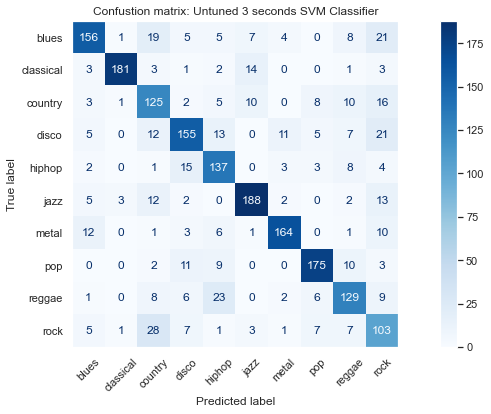

Accuracy : 0.76
Macro F-1 Score : 0.75


In [8]:
# Evaluate Model on Test set
class_labels = list(model_svm.classes_)
macro_f1, accuracy = evaluate_model(predsTestsvm, y_test, class_labels,
                                    'Confustion matrix: Untuned 3 seconds SVM Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [9]:
parameters = {"kernel": ['linear', 'rbf', 'sigmoid'],
            "C": [0.001, 0.01, 0.1, 1, 10],
            "gamma": [0.001, 0.01, 0.1, 1]}
print(parameters)

{'kernel': ['linear', 'rbf', 'sigmoid'], 'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}


In [10]:
tune_svm = GridSearchCV(estimator = model_svm, param_grid = parameters, cv = 5)
tune_svm.fit(X_dev, y_dev)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'sigmoid']})

In [11]:
print("Best Score :", tune_svm.best_score_)
print("Best Parameters :",tune_svm.best_params_)

Best Score : 0.8997747340523372
Best Parameters : {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [12]:
predsDevsvm_tuned = tune_svm.predict(X_dev)
predsTestsvm_tuned = tune_svm.predict(X_test)

print("Score on Dev data for svm using GridSearchCV:", accuracy_score(y_dev, predsDevsvm_tuned))
print("Score on Test data for svm using GridSearchCV:",accuracy_score(y_test, predsTestsvm_tuned))

Score on Dev data for svm using GridSearchCV: 0.9821071071071071
Score on Test data for svm using GridSearchCV: 0.9024024024024024


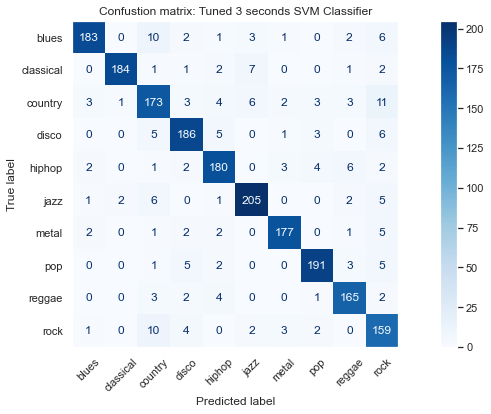

Accuracy : 0.90
Macro F-1 Score : 0.90


In [13]:
# Evaluate Model on Test set
class_labels = list(model_svm.classes_)
macro_f1, accuracy = evaluate_model(predsTestsvm_tuned, y_test, class_labels,
                                    'Confustion matrix: Tuned 3 seconds SVM Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Dimensionality reduction of data using PCA

In [14]:
# Principal Component Analysis 
### cite : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

# create the PCA instance
pca = PCA(n_components=30)
# fit on data
pca_data = pca.fit_transform(X_dev)
pca_data_test = pca.transform(X_test)
# pca_data_dev = pca.transform(X_dev)
PCA_df= pd.DataFrame(data=pca_data)
y_dev.index = PCA_df.index
pca_final=pd.concat([PCA_df,y_dev], axis = 1)
# access values
print("Explained Variance of each component:",pca.explained_variance_)
print("Sum of Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance of each component: [0.16211049 0.11190511 0.04944364 0.03409667 0.03089104 0.02431167
 0.0172229  0.01586461 0.01282323 0.01102709 0.00926644 0.00886366
 0.00802953 0.00707012 0.00658936 0.00623254 0.00547413 0.00528015
 0.00521749 0.00492067 0.00474663 0.00425811 0.00403033 0.00356595
 0.00341528 0.00335207 0.00301288 0.00297556 0.00291521 0.00280227]
Sum of Explained Variance: 0.9389030196431886


In [15]:
pca_final.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,0.072299,-0.412844,0.023072,-0.417214,0.299826,-0.088897,-0.140613,-0.010049,-0.051660,-0.117344,...,0.023974,0.139442,0.010958,-0.037305,-0.027281,0.014821,-0.032529,0.120200,-0.000187,metal
1,0.274582,-0.006478,-0.298496,-0.242299,0.143267,0.006232,-0.135089,0.275192,-0.056226,-0.017919,...,0.029786,0.048155,0.018354,-0.025351,-0.003861,0.010424,-0.046463,0.043020,-0.000627,jazz
2,0.317181,-0.069387,-0.276547,-0.327404,0.098026,0.062285,-0.227108,-0.017663,-0.096368,-0.190205,...,-0.008394,0.091454,0.047272,0.015942,-0.002573,-0.007258,-0.077811,0.117515,-0.083279,country
3,-0.291017,-0.097326,0.154852,-0.012074,0.073026,-0.022697,0.001457,0.070611,0.046648,-0.093304,...,0.032545,0.006338,0.039358,0.065881,0.060195,0.073804,0.037043,-0.119953,0.103407,country
4,-0.879330,0.313246,-0.219645,0.027578,0.029235,-0.272867,0.007777,-0.127960,-0.002711,0.007407,...,0.036362,0.021828,0.030537,-0.012574,-0.085962,-0.034361,-0.036754,-0.013333,0.008847,classical


### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [16]:
model_pca = SVC()
model_pca.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainsvm = model_pca.predict(pca_data)
pcaTestsvm = model_pca.predict(pca_data_test)

In [17]:
pcatestsvm_score =  accuracy_score(y_test, pcaTestsvm)
pcasvm_score = accuracy_score(y_dev, pcaTrainsvm)

In [18]:
print("Classification Score for SVM Classifier on Train dataset:\n")
print("Train Score : ", pcasvm_score)
print("--------------------------------------------------------")
print("Classification Score for SVM Classifier on Test dataset:\n")
print("Test Score :", pcatestsvm_score)

Classification Score for SVM Classifier on Train dataset:

Train Score :  0.8930180180180181
--------------------------------------------------------
Classification Score for SVM Classifier on Test dataset:

Test Score : 0.8458458458458459


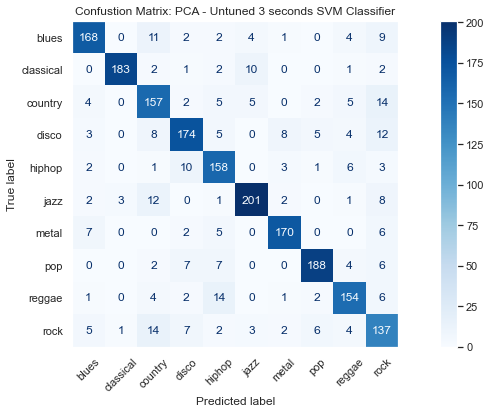

Accuracy : 0.85
Macro F-1 Score : 0.85


In [19]:
# Evaluate Model
class_labels = list(model_svm.classes_)
macro_f1, accuracy = evaluate_model(pcaTestsvm, y_test, class_labels,
                                    'Confustion Matrix: PCA - Untuned 3 seconds SVM Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [20]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.072299,-0.412844,0.023072,-0.417214,0.299826,-0.088897,-0.140613,-0.010049,-0.051660,-0.117344,...,-0.052338,0.023974,0.139442,0.010958,-0.037305,-0.027281,0.014821,-0.032529,0.120200,-0.000187
1,0.274582,-0.006478,-0.298496,-0.242299,0.143267,0.006232,-0.135089,0.275192,-0.056226,-0.017919,...,-0.012337,0.029786,0.048155,0.018354,-0.025351,-0.003861,0.010424,-0.046463,0.043020,-0.000627
2,0.317181,-0.069387,-0.276547,-0.327404,0.098026,0.062285,-0.227108,-0.017663,-0.096368,-0.190205,...,0.054940,-0.008394,0.091454,0.047272,0.015942,-0.002573,-0.007258,-0.077811,0.117515,-0.083279
3,-0.291017,-0.097326,0.154852,-0.012074,0.073026,-0.022697,0.001457,0.070611,0.046648,-0.093304,...,-0.006638,0.032545,0.006338,0.039358,0.065881,0.060195,0.073804,0.037043,-0.119953,0.103407
4,-0.879330,0.313246,-0.219645,0.027578,0.029235,-0.272867,0.007777,-0.127960,-0.002711,0.007407,...,-0.078777,0.036362,0.021828,0.030537,-0.012574,-0.085962,-0.034361,-0.036754,-0.013333,0.008847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7987,0.377397,-0.033968,-0.295756,-0.057190,0.151605,0.131654,0.035457,0.102116,-0.002044,0.054450,...,-0.064356,0.012090,0.017592,0.046540,0.039262,-0.063755,-0.033919,-0.009281,0.025319,-0.014132
7988,-0.213167,-0.620013,-0.158077,0.127757,0.026842,-0.228275,0.075253,0.001353,0.024659,-0.152166,...,0.003995,-0.026448,0.038580,-0.027174,-0.008549,0.001663,-0.030194,0.014002,0.008485,-0.036773
7989,0.376878,-0.370960,0.473148,-0.024045,-0.082251,0.189682,0.059470,0.106887,0.152496,0.122058,...,-0.003134,0.110313,0.009113,0.141782,0.012516,-0.033986,0.077754,0.033262,0.016835,-0.098809
7990,-0.395842,0.347525,-0.030945,-0.205586,0.025497,-0.198468,-0.050449,-0.159271,-0.205599,0.063863,...,-0.080162,-0.030218,-0.007740,0.022965,-0.057079,0.047838,0.136545,0.008035,-0.048488,-0.011442


In [21]:
model_pca_tuned = tune_svm
model_pca_tuned.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainsvm_tuned = model_pca_tuned.predict(pca_data)
pcaTestsvm_tuned = model_pca_tuned.predict(pca_data_test)

In [22]:
pcatestsvm_score =  accuracy_score(y_test, pcaTestsvm)
pcasvm_score = accuracy_score(y_dev, pcaTrainsvm)

In [23]:
print("Classification Score for SVM Classifier on Train dataset:\n")
print("Train Score : ", pcasvm_score)
print("--------------------------------------------------------")
print("Classification Score for SVM Classifier on Test dataset:\n")
print("Test Score :", pcatestsvm_score)

Classification Score for SVM Classifier on Train dataset:

Train Score :  0.8930180180180181
--------------------------------------------------------
Classification Score for SVM Classifier on Test dataset:

Test Score : 0.8458458458458459


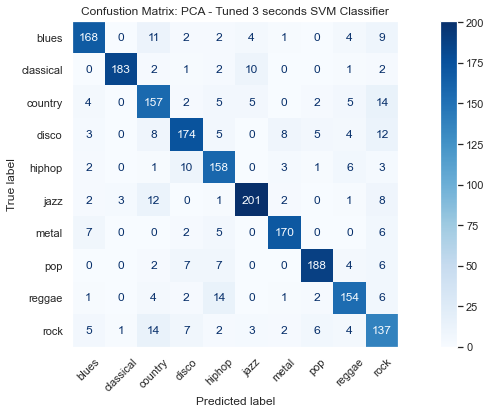

Accuracy : 0.85
Macro F-1 Score : 0.85


In [24]:
# Evaluate Model
class_labels = list(model_svm.classes_)
macro_f1, accuracy = evaluate_model(pcaTestsvm, y_test, class_labels,
                                    'Confustion Matrix: PCA - Tuned 3 seconds SVM Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)